# Previsão de vendas de produtos de mercearia 
by: Adriel Ferreira e Kamily Assis

### Bibliotecas e Dataframe

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import acf, plot_acf, plot_pacf
from statsmodels.tsa.stattools import pacf, adfuller

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from sklearn.linear_model import TweedieRegressor, LinearRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

import warnings
warnings.filterwarnings("ignore")


In [75]:
df = pd.read_csv('dataset/corporacion-favorit/store44.csv')

df.head()

,id,date,store_nbr,family,quantity,onpromotion
0,3036,2013-01-02,44,AUTOMOTIVE,16.000,0
1,3068,2013-01-02,44,SEAFOOD,150.367,0
2,3065,2013-01-02,44,PREPARED FOODS,616.862,0
3,3064,2013-01-02,44,POULTRY,1034.765,0
4,3061,2013-01-02,44,PERSONAL CARE,716.000,0


### Estatísticas Descritivas

In [40]:
print('maior venda:')
print(df.loc[df['quantity'].idxmax()])

print('')
print('menor venda:')
print(df.loc[df['quantity'].idxmin()])

maior venda:
id                 562596
date           2013-11-12
store_nbr              44
family          GROCERY I
quantity          46271.0
onpromotion             0
Name: 6668, dtype: object

menor venda:
id                   4832
date           2013-01-03
store_nbr              44
family           HARDWARE
quantity              1.0
onpromotion             0
Name: 20, dtype: object


In [41]:
df['quantity'].describe()

#mean = média aritmética
#std = desvio padrão

count    45598.000000
mean      1361.628871
std       2907.794710
min          1.000000
25%         24.000000
50%        281.752000
75%        997.610750
max      46271.000000
Name: quantity, dtype: float64

## Serie

In [42]:
produto_mv = ['GROCERY I']
produtos_mv = ['BEVERAGES', 'PRODUCE', 'CLEANING']

### Transformando em Serie

In [76]:
df = df.set_index('date')
df = df.sort_index(inplace=False)

In [35]:
def transf_serie(df, produto):

    serie = df[df['family'] == produto]['quantity']

    return serie

In [7]:
series_df = {}

series_df['GROCERY I'] = transf_serie(df, produto_mv[0])

series_df

{'GROCERY I': date
 2013-01-02    10686.0
 2013-01-03     7342.0
 2013-01-04     7250.0
 2013-01-05    10699.0
 2013-01-06    12373.0
                ...   
 2017-08-11     9979.0
 2017-08-12     9391.0
 2017-08-13     9811.0
 2017-08-14     8318.0
 2017-08-15     8123.0
 Name: quantity, Length: 1679, dtype: float64}

## Analise Exploratoria das Series

### Componentes Básicas da Serie

In [8]:
def analise_serie(series_df, prod):

    print('')
    
    print(f'Estatisticas de {prod}')

    print(series_df[prod].describe())

    print('---'*30)

In [9]:
analise_serie(series_df, produto_mv[0])


Estatisticas de GROCERY I
count     1679.000000
mean      9759.413364
std       3541.684894
min       2990.000000
25%       7292.000000
50%       8808.000000
75%      11665.000000
max      46271.000000
Name: quantity, dtype: float64
------------------------------------------------------------------------------------------


### Estacionaridade da Serie

In [10]:
def adf_serie(series_df, prod):

    print('')

    result = adfuller(series_df[prod])
    p_value = result[1]


    if p_value > 0.05:
        print(f"A série {prod} não é estacionária. Diferenciação necessária.")
    else:
        print(f"A série {prod} é estacionária. Nenhuma diferenciação necessária.")

    media_movel = series_df[prod].rolling(window=12).mean()
    desvio_padrao = series_df[prod].std()

    plt.figure(figsize=(20, 5))
    plt.plot(series_df[prod], color='deepskyblue')
    plt.plot(media_movel, color='orange', linestyle='--', label='media movel')

    plt.axhline(series_df[prod].mean() + desvio_padrao, color='green', linestyle='--', label='intervalo de concentração')
    plt.axhline(series_df[prod].mean() - desvio_padrao, color='green', linestyle='--')
    plt.axhline(series_df[prod].mean(), color='red', linestyle='--', label='media')
    
    plt.title('Estacionaridade de ' + prod)
    plt.xlabel('Tempo')
    plt.ylabel('Quantity')
    plt.legend()
    plt.show()

    print('---'*60)
    print('')


A série GROCERY I é estacionária. Nenhuma diferenciação necessária.


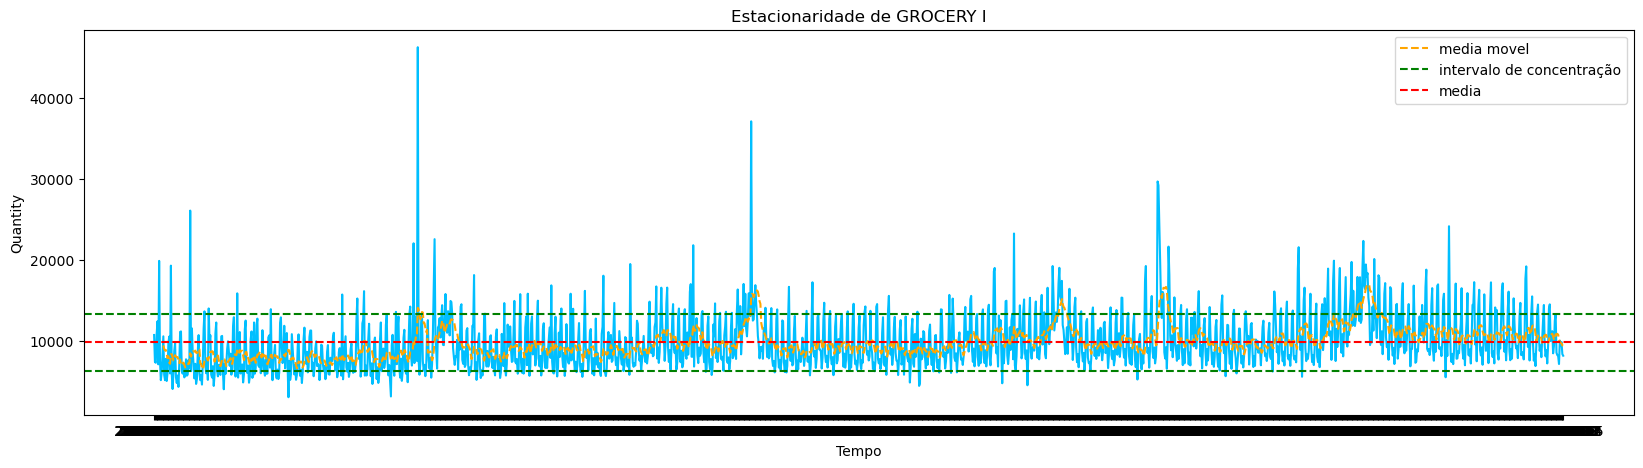

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------



In [11]:
adf_serie(series_df, produto_mv[0])

### Decomposição Sazonal

In [12]:
def decomposition(series_df, prod, period=12):

    print('')
    print(f'Decomposição de {prod}')

    decomposition = seasonal_decompose(series_df[prod], model='additive', period=period)

    trend = decomposition.trend
    seasonal = decomposition.seasonal
    resid = decomposition.resid

    fig, ax=plt.subplots(4, 1, figsize=(20, 11))

    ax[0].plot(series_df[prod], color='deepskyblue')
    ax[0].set_title('Serie')

    ax[1].plot(decomposition.trend, color='red')
    ax[1].set_title('Tendência')

    ax[2].plot(decomposition.seasonal, color='limegreen')
    ax[2].set_title('Sazonalidade')

    ax[3].plot(decomposition.resid, color='orange')
    ax[3].set_title('Resíduo')

    plt.tight_layout()
    plt.show()

    print('---'*50)

    return trend, seasonal, resid


Decomposição de GROCERY I


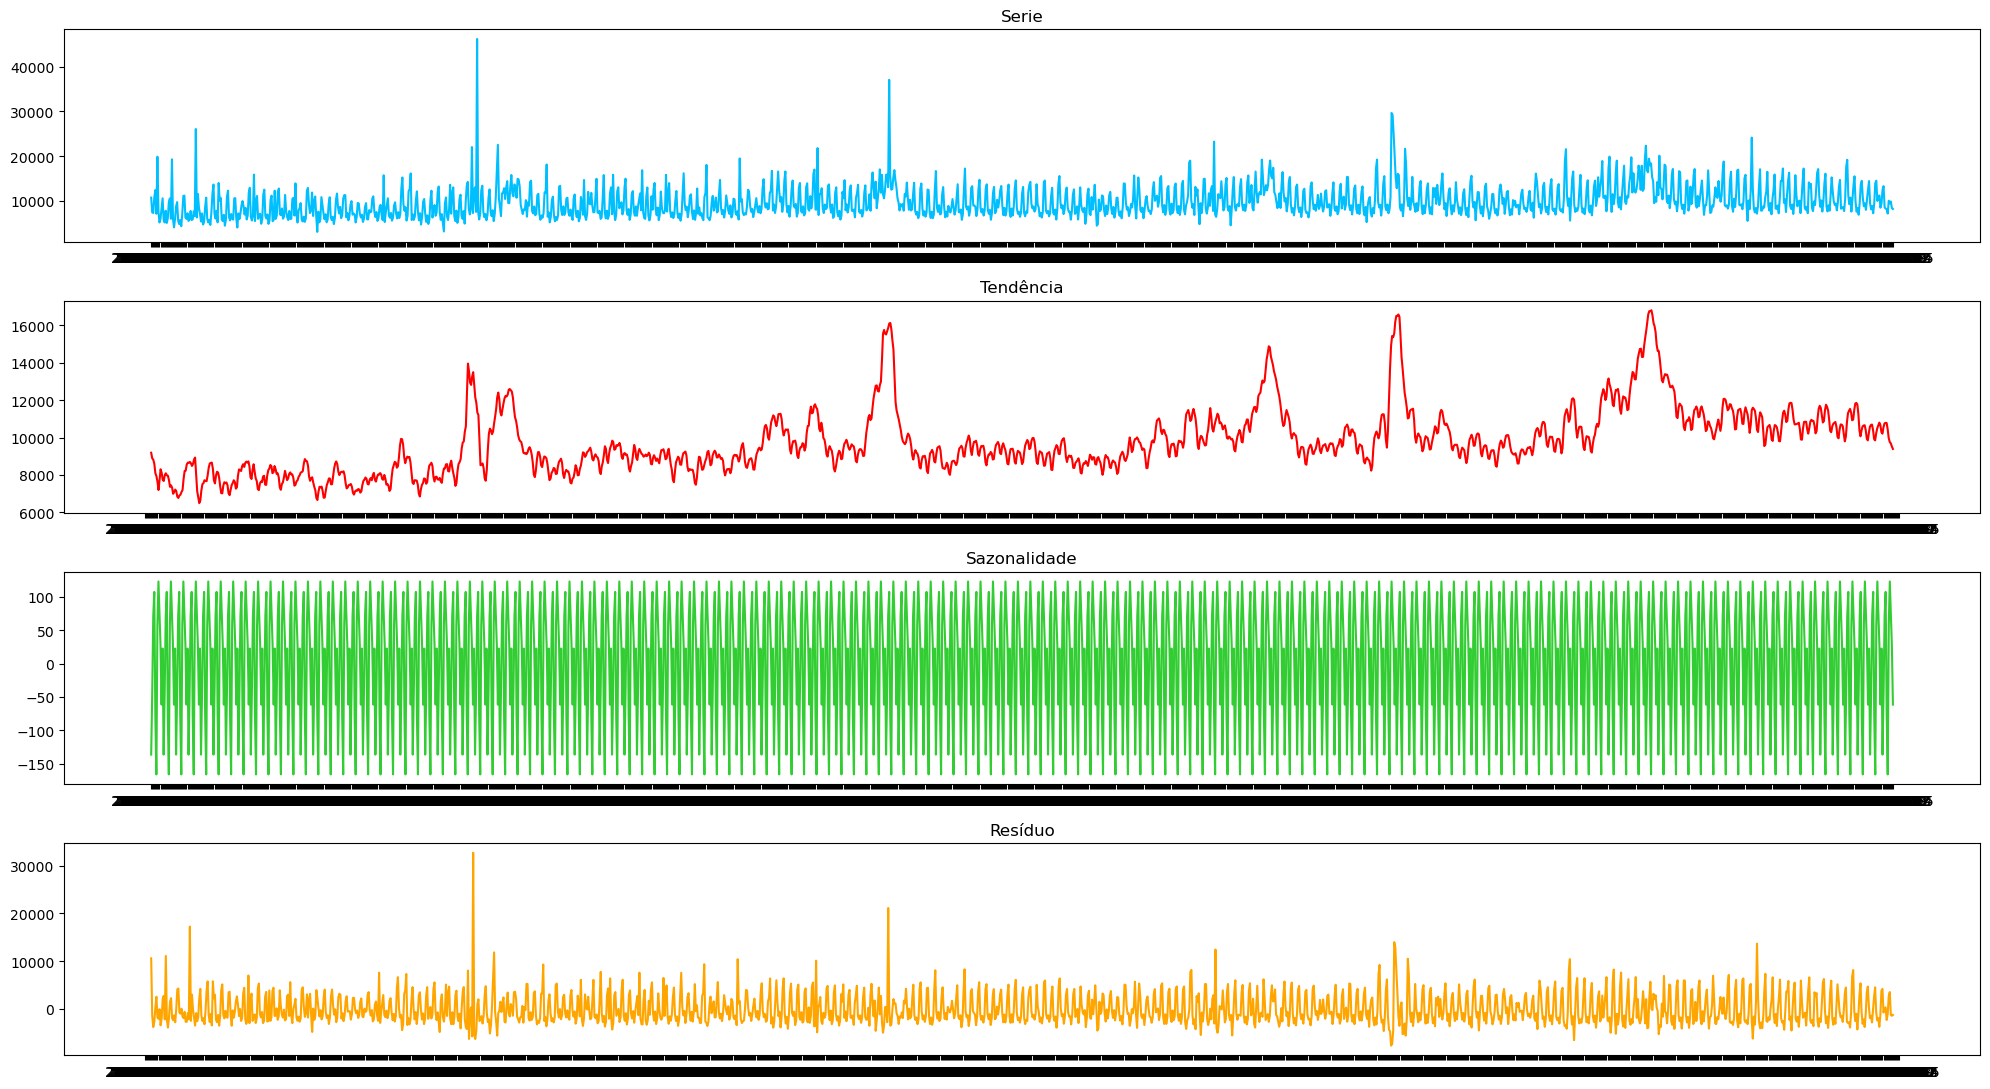

------------------------------------------------------------------------------------------------------------------------------------------------------


In [13]:
caracteristicas = {}

trend_mv, seasonal_mv, resid_mv = decomposition(series_df, produto_mv[0], 12)

caracteristicas[produto_mv[0]] = [trend_mv, seasonal_mv, resid_mv]

### Autocorrelação dos resíduos das Series (ACF e PACF)

In [14]:
def acf_resid(series_df, prod):

    print('')
    print(f'Gráficos da Autocorrelação dos resíduos de {prod}')

    plt.figure(figsize=(10, 6))
    plot_acf(series_df[prod], lags=7, ax=plt.gca())
    plt.ylabel('Autocorrelação')
    plt.title(f'Autocorrelação (ACF) da Serie de {prod}')
    plt.show()

def pacf_resid(series_df, prod):

    plt.figure(figsize=(10, 6))
    plot_pacf(series_df[prod], lags=7, ax=plt.gca())
    plt.ylabel('Autocorrelação')
    plt.title(f'Autocorrelação Parcial (PACF) da Serie de {prod}')
    plt.show()

    print('')
    print('---'*40)



Gráficos da Autocorrelação dos resíduos de GROCERY I


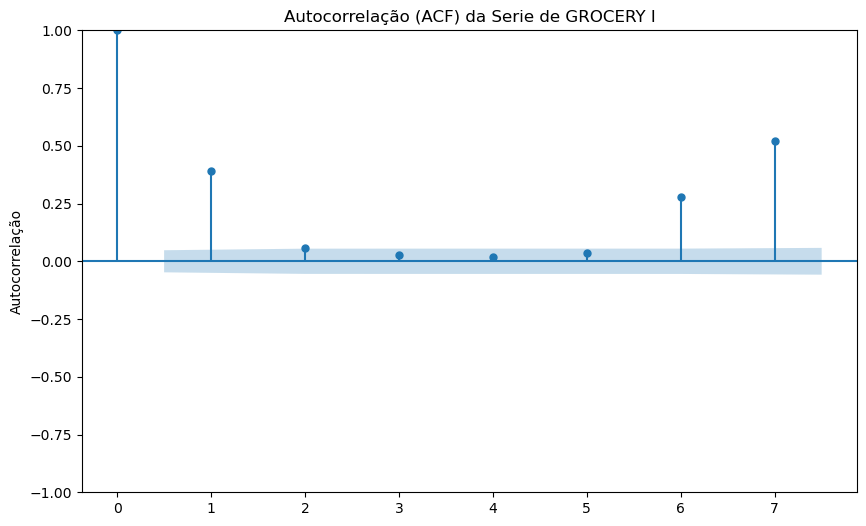

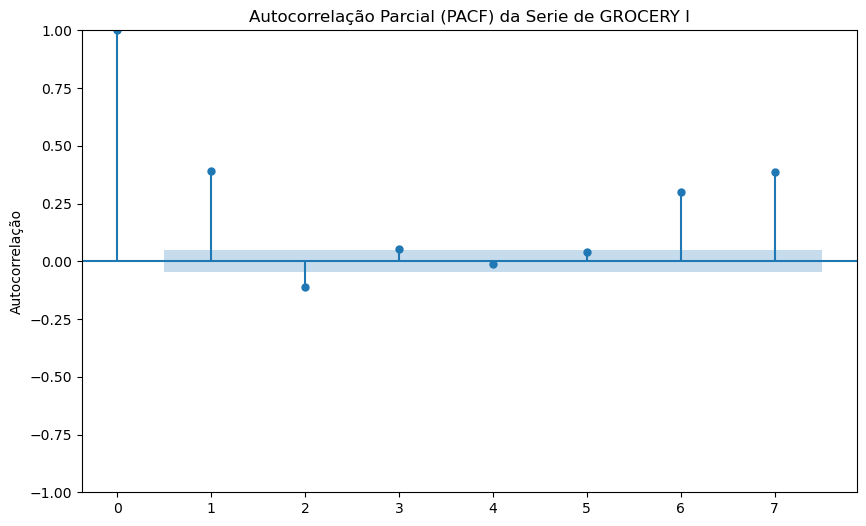


------------------------------------------------------------------------------------------------------------------------


In [15]:
acf_resid(series_df, produto_mv[0])

pacf_resid(series_df, produto_mv[0])

### Transformando Series em Dataframes

In [16]:
dataframes_series = {}

dataframes_series[produto_mv[0]] = pd.DataFrame(series_df[produto_mv[0]])

dataframes_series[produto_mv[0]]


,quantity
date,
2013-01-02,10686.0
2013-01-03,7342.0
2013-01-04,7250.0
2013-01-05,10699.0
2013-01-06,12373.0
...,...
2017-08-11,9979.0
2017-08-12,9391.0
2017-08-13,9811.0


### Outliers

#### Identificação dos Outliers

In [17]:
def outliers(df_serie, produto):

    print('Outliers de ', produto)

    if 'quantity' not in df_serie[produto].columns:
        raise ValueError(f"A coluna 'quantity' não existe no DataFrame para o produto {produto}")


    df_serie[produto]['quantity'].plot.box()
    plt.title('Quantidade')
    plt.show()

    print('')

    z_scores = stats.zscore(df_serie[produto]['quantity'])
    outliers = df_serie[produto][np.abs(z_scores) > 3]

    print(f"Número de outliers: {outliers.shape[0]}")

    print(outliers)

    print('')
    print('---'*40)
    print('')
    
    return outliers

Outliers de  GROCERY I


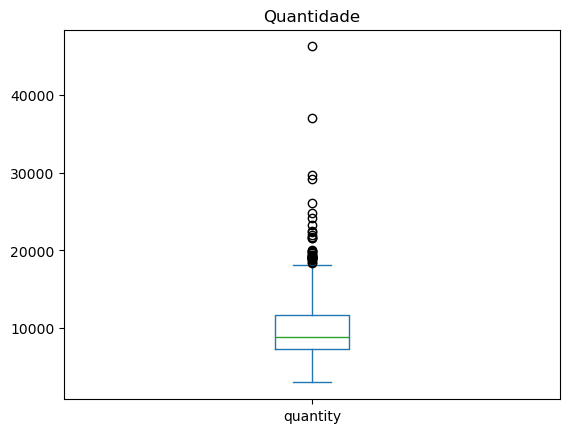


Número de outliers: 14
            quantity
date                
2013-02-14   26067.0
2013-11-07   22024.0
2013-11-12   46271.0
2013-12-02   22534.0
2014-10-08   21785.0
2014-12-16   37106.0
2015-10-27   23233.0
2016-04-17   29670.0
2016-04-18   29193.0
2016-04-19   24861.0
2016-04-30   21613.0
2016-10-02   21540.0
2016-12-18   22318.0
2017-04-01   24134.0

------------------------------------------------------------------------------------------------------------------------



In [18]:
outliers_tds = {}

outliers_tds[produto_mv[0]] = outliers(dataframes_series, produto_mv[0])

#### Remoção dos Outliers

In [19]:
def remove_outliers(outliers, df):

    df_sem_outliers = df[~df.index.isin(outliers.index)]

    return df_sem_outliers

In [20]:
df_sem_outliers = {}

df_sem_outliers[produto_mv[0]] = remove_outliers(outliers_tds[produto_mv[0]], dataframes_series[produto_mv[0]])

df_sem_outliers[produto_mv[0]]

,quantity
date,
2013-01-02,10686.0
2013-01-03,7342.0
2013-01-04,7250.0
2013-01-05,10699.0
2013-01-06,12373.0
...,...
2017-08-11,9979.0
2017-08-12,9391.0
2017-08-13,9811.0


### CSV's Df's sem outliers

In [343]:
#for df in df_sem_outliers:

   #df_sem_outliers[df].to_csv(f'dataset/corporacion-favorit/df_sem_outliers/{df}_sem_outliers.csv')

# Modelos

In [21]:
def metricas(y_true, y_pred):

    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    '''print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    print(f'MAPE: {mape}')
    print(f'R2: {r2}')
'''
    return r2, mse, rmse, mape

In [26]:
df.columns

Index(['id', 'date', 'store_nbr', 'family', 'quantity', 'onpromotion'], dtype='object')

## Regressão Linear

In [81]:
def calling_LR(family):

    df_family = df[df['family'] == family].copy()
    #df.set_index('date', inplace=True)
    #df.index = pd.to_datetime(df.index)

    X = df_family[['onpromotion']] 
    scaler = MinMaxScaler()
    X_ = scaler.fit_transform(X)
    print(X_)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_)
    y = df_family['quantity']


    # Train-test split based on a date
    X_train = X_scaled[X.index < '2016-10-24']
    X_test = X_scaled[X.index >= '2016-10-24']
    y_train = y[y.index < '2016-10-24']
    y_test = y[y.index >= '2016-10-24']
    #y_test = y_test.dropna()

    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)


    return y_train, y_test, y_pred

def compare_LR(y_train, y_test, y_pred):
    df_compare = pd.DataFrame({
        'y_test': y_test,
        'y_pred': y_pred
    })

    # Plot the comparison
    plt.figure(figsize=(20, 5))
    plt.plot(y_train, label='Train Values', color='deepskyblue')
    plt.plot(df_compare['y_test'], label='Test Values', color='limegreen')
    plt.plot(df_compare['y_pred'], label='Predicted Values', color='red', linestyle='--')
    plt.legend()
    plt.title(f'Actual vs Predicted Values ({LinearRegression.__name__})')
    plt.xlabel('Index')
    plt.ylabel('Quantity')
    plt.show()

    return df_compare


[[0.        ]
 [0.        ]
 [0.        ]
 ...
 [0.2029703 ]
 [0.19306931]
 [0.18316832]]


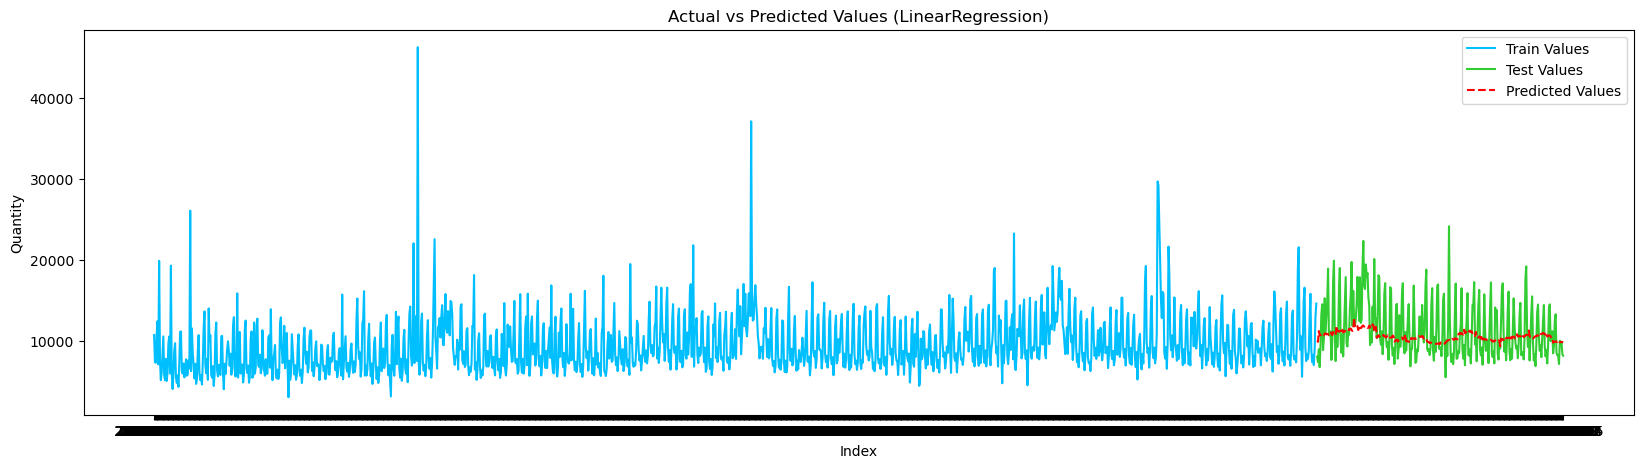

,y_test,y_pred
date,,
2016-10-24,7994.0,9990.928085
2016-10-25,7332.0,9843.662492
2016-10-26,8908.0,11169.052831
2016-10-27,6708.0,10635.215055
2016-10-28,9419.0,10708.847852
...,...,...
2017-08-11,9979.0,9788.437895
2017-08-12,9391.0,9806.846094
2017-08-13,9811.0,9843.662492


In [82]:
y_train_LR, y_test_LR, y_pred_LR = calling_LR('GROCERY I')
compare_LR(y_train_LR, y_test_LR, y_pred_LR)

In [56]:
y_test_LR

date
2016-10-24    7994.0
2016-10-25    7332.0
2016-10-26    8908.0
2016-10-27    6708.0
2016-10-28    9419.0
               ...  
2017-08-11    9979.0
2017-08-12    9391.0
2017-08-13    9811.0
2017-08-14    8318.0
2017-08-15    8123.0
Name: quantity, Length: 294, dtype: float64

## ARIMA

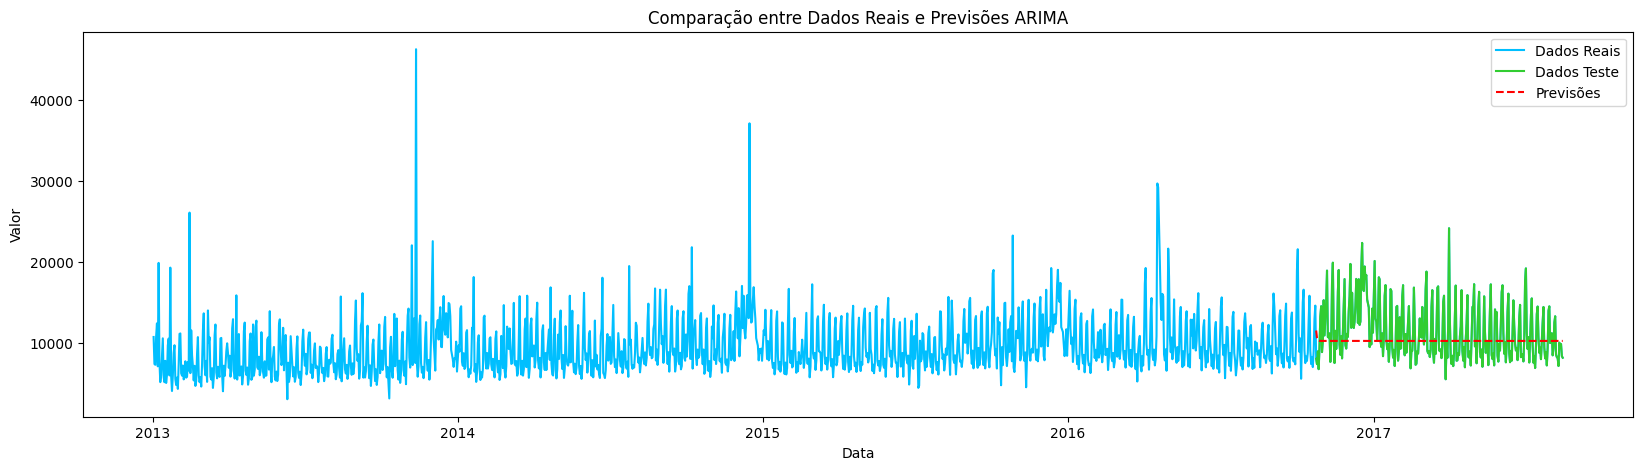

In [516]:
def calling_arima(serie, order=(1, 1, 1)):
    
    serie.index = pd.to_datetime(serie.index)
    serie = serie.asfreq('D', method=None)  

    
    y_train = serie[serie.index < '2016-10-24']
    y_test = serie[serie.index >= '2016-10-24']
    y_test = y_test.dropna()

    
    model = ARIMA(y_train, order=order)
    model_fit = model.fit()


    predictions = model_fit.forecast(steps=len(y_test))

    return y_test, predictions


def compare_arima(serie, y_test, predictions):

    df_compare = pd.DataFrame({
        'y_test': y_test.values,
        'y_pred': predictions.values
    }, index=y_test.index)

    fig, ax = plt.subplots(figsize=(20, 5))
    
    
    plt.plot(serie.index, serie.values, label='Dados Reais', color='deepskyblue')    
    plt.plot(y_test.index, y_test.values, label='Dados Teste', color='limegreen')
    plt.plot(df_compare.index, df_compare['y_pred'], label='Previsões', color='red', linestyle='--')

    plt.legend()
    plt.title('Comparação entre Dados Reais e Previsões ARIMA')
    plt.xlabel('Data')
    plt.ylabel('Valor')
    plt.show()


my_s = series_df['GROCERY I']
y_test_ARIMA, predictions_ARIMA = calling_arima(my_s, order=(1, 1, 1))
compare_arima(my_s, y_test_ARIMA, predictions_ARIMA)

In [517]:
#my_s_o = df_sem_outliers['GROCERY I']
#y_test_ARIMA, predictions_ARIMA = calling_arima(my_s_o, order=(1, 1, 1))
#compare_arima(my_s_o, y_test_ARIMA, predictions_ARIMA)

## Suavização Exponencial

C:\Users\kamil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\kamil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\kamil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\kamil\AppData\Local\Packages\PythonSoft

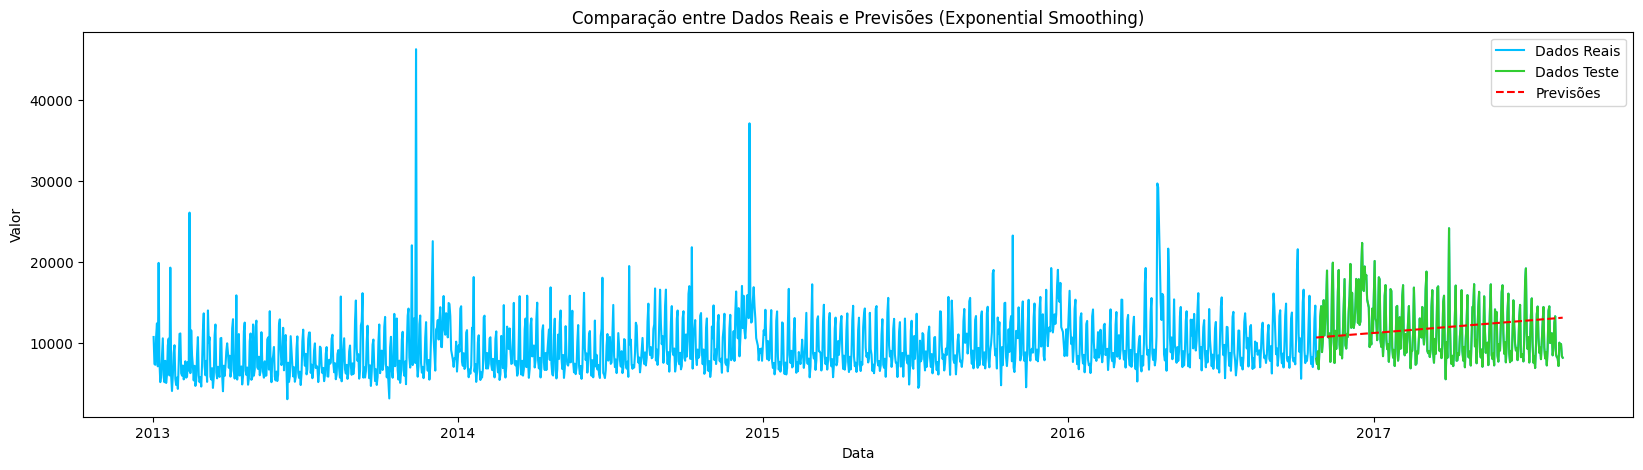

In [518]:
def calling_exponential_smoothing(serie, trend='add', seasonal=None, seasonal_periods=None):
    
    serie.index = pd.to_datetime(serie.index)
    
    y_train = serie[serie.index < '2016-10-24']
    y_test = serie[serie.index >= '2016-10-24']

    # Ajustar o modelo Exponential Smoothing
    model = ExponentialSmoothing(
        y_train,
        trend=trend,  # 'add' para tendência aditiva, 'mul' para multiplicativa, None se não houver tendência
        seasonal=None  # Periodicidade sazonal (se aplicável)
    )
    model_fit = model.fit()
    predictions = model_fit.forecast(steps=len(y_test))

    return y_test, predictions

def compare_exponential_smoothing(serie, y_test, predictions):

    df_compare = pd.DataFrame({
        'y_test': y_test.values,
        'y_pred': predictions.values
    }, index=y_test.index)

    fig, ax = plt.subplots(figsize=(20, 5))
    
    plt.plot(serie.index, serie.values, label='Dados Reais', color='deepskyblue')
    plt.plot(y_test.index, y_test.values, label='Dados Teste', color='limegreen')
    plt.plot(df_compare.index, df_compare['y_pred'], label='Previsões', color='red', linestyle='--')

    plt.legend()
    plt.title('Comparação entre Dados Reais e Previsões (Exponential Smoothing)')
    plt.xlabel('Data')
    plt.ylabel('Valor')
    plt.show()


my_s = series_df['GROCERY I']
y_test_SE, predictions_SE = calling_exponential_smoothing(my_s, trend='add', seasonal=None, seasonal_periods=None)
compare_exponential_smoothing(my_s, y_test_SE, predictions_SE)


## Tweedie Regressor

C:\Users\kamil\AppData\Local\Temp\ipykernel_14328\4035333505.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  serie = serie.fillna(method='ffill')


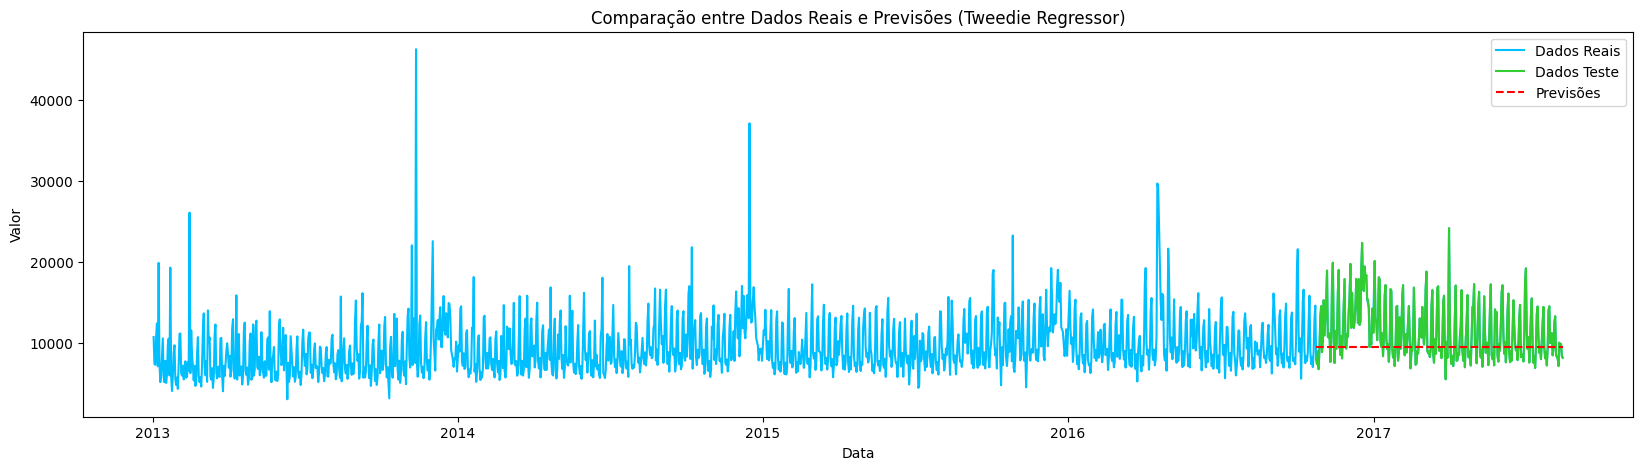

In [519]:
def calling_tweedie_regressor(serie, power=1.0):
    
    #a conversão garante a frequência diária
    serie.index = pd.to_datetime(serie.index)
    serie = serie.asfreq('D', method=None)
    
    #preenche valores ausentes, se houver
    serie = serie.fillna(method='ffill')
    
    y_train = serie[serie.index < '2016-10-24']
    y_test = serie[serie.index >= '2016-10-24']
    
    X_train = np.arange(len(y_train)).reshape(-1, 1)
    X_test = np.arange(len(y_train), len(y_train) + len(y_test)).reshape(-1, 1)

    model = TweedieRegressor(power=power)
    model.fit(X_train, y_train)
    
    predictions = model.predict(X_test)
    
    return y_test, predictions

def compare_tweedie_regressor(serie, y_test, predictions):

    df_compare = pd.DataFrame({
        'y_test': y_test.values,
        'y_pred': predictions
    }, index=y_test.index)

    fig, ax = plt.subplots(figsize=(20, 5))
    
    plt.plot(serie.index, serie.values, label='Dados Reais', color='deepskyblue')
    plt.plot(y_test.index, y_test.values, label='Dados Teste', color='limegreen')
    plt.plot(df_compare.index, df_compare['y_pred'], label='Previsões', color='red', linestyle='--')

    plt.legend()
    plt.title('Comparação entre Dados Reais e Previsões (Tweedie Regressor)')
    plt.xlabel('Data')
    plt.ylabel('Valor')
    plt.show()

my_s = series_df['GROCERY I']
y_test_TR, predictions_TR = calling_tweedie_regressor(my_s, power=1.0)
compare_tweedie_regressor(my_s, y_test_TR, predictions_TR)


# Metricas de Erro

In [520]:
metricas_ARIMA = metricas(y_test_ARIMA, predictions_ARIMA)
metricas_SE = metricas(y_test_SE, predictions_SE)
metricas_TR = metricas(y_test_TR, predictions_TR)

metricas_erro = [metricas_ARIMA, metricas_SE, metricas_TR]

In [521]:
#df_metricas = {'Arima com Outliers': {}, 'Arima sem Outliers': {}, 'Suavização Exponencial': {}, 'Tweedie Regressor': {}}
#df_metricas = {'Arima com Outliers': {}, 'Suavização Exponencial': {}, 'Tweedie Regressor': {}}
df_metricas = {'Arima': {}, 'Suav Exp': {}, 'Tweedie Reg': {}}
nomes_metricas = ['R2', 'MSE', 'RMSE', 'MAPE']

for modelo in df_metricas.keys():
    idx = list(df_metricas.keys()).index(modelo)
    for i, nome_metrica in enumerate(nomes_metricas):
        if idx < len(metricas_erro):
            df_metricas[modelo][nome_metrica] = float(metricas_erro[idx][i])
        else:
            df_metricas[modelo][nome_metrica] = None


df_metricas = pd.DataFrame(df_metricas)

df_metricas = df_metricas.round(2)

df_metricas

,Arima,Suav Exp,Tweedie Reg
R2,-0.12,-0.16,-0.33
MSE,13478744.41,13931215.77,15983167.03
RMSE,3671.34,3732.45,3997.90
MAPE,0.22,0.29,0.22


In [522]:
df_metricas.T

,R2,MSE,RMSE,MAPE
Arima,-0.12,13478744.41,3671.34,0.22
Suav Exp,-0.16,13931215.77,3732.45,0.29
Tweedie Reg,-0.33,15983167.03,3997.90,0.22
